# GNN with explicit intermolecular interactions

## Load packages

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 48.5 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [ ]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.3 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=f2b44ba1b7b4e447f1e1377ca50b3e8379b0f2fb386d973b6052dd6a92ee415e
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently t

In [1]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
import sklearn
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset
from torch_geometric.utils import scatter
from torch_geometric.data import Batch
from torch.utils.data import Dataset
import networkx as nx
from torch_geometric.utils import to_networkx

# RDKit
import rdkit
from rdkit import Chem
import mordred
from mordred.Polarizability import APol, BPol
from mordred.TopoPSA import TopoPSA
from rdkit.Chem import rdMolDescriptors
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
print('Mordred version:', mordred.__version__)
tqdm.pandas()

ModuleNotFoundError: No module named 'torch_geometric'

## Load data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Work/Projects/GNN_DES/GNN_model/processed_data/

/content/drive/MyDrive/Work/Projects/GNN_DES/GNN_model/processed_data


In [ ]:
df = pd.read_csv('DES_data_clean_random.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239 entries, 0 to 1238
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HBA              1239 non-null   object 
 1   HBD              1239 non-null   object 
 2   T(K)             1239 non-null   float64
 3   Density (kg/m3)  1239 non-null   float64
 4   rate_HBA         1239 non-null   float64
 5   rate_HBD         1239 non-null   float64
 6   HBA_SMILES       1239 non-null   object 
 7   HBD_SMILES       1239 non-null   object 
 8   Split            1239 non-null   object 
dtypes: float64(4), object(5)
memory usage: 87.2+ KB


## Create molecules

In [ ]:
df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)

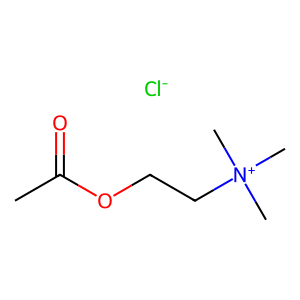

In [ ]:
from rdkit.Chem import Draw
Draw.MolToImage(df.loc[0,'mol_hba'])

## Compute molecular descriptors

### Atomic polarizability

In [ ]:
ap_fun = APol()
df['ap_hba'] = df['mol_hba'].apply(ap_fun)
df['ap_hbd'] = df['mol_hbd'].apply(ap_fun)

### Bond polarizability

In [ ]:
bp_fun = BPol()
df['bp_hba'] = df['mol_hba'].apply(bp_fun)
df['bp_hbd'] = df['mol_hbd'].apply(bp_fun)

### Topological polar surface area

In [ ]:
topopsa_fun = TopoPSA()
df['topopsa_hba'] = df['mol_hba'].apply(topopsa_fun)
df['topopsa_hbd'] = df['mol_hbd'].apply(topopsa_fun)

### Intra-molecular hydrogen-bonding sites

In [ ]:
def get_hb_sites(mol):
  return min(rdMolDescriptors.CalcNumHBA(mol), rdMolDescriptors.CalcNumHBD(mol))

df['hb_hba'] = df['mol_hba'].apply(get_hb_sites)
df['hb_hbd'] = df['mol_hbd'].apply(get_hb_sites)

### Inter-molecular hydrogen bonding sites

In [ ]:
def get_inter_hb_sites(row):
    mol1 = row['mol_hba']
    mol2 = row['mol_hbd']
    return min(rdMolDescriptors.CalcNumHBA(mol1), rdMolDescriptors.CalcNumHBD(mol2)) + \
           min(rdMolDescriptors.CalcNumHBA(mol2), rdMolDescriptors.CalcNumHBD(mol1))


df['inter_hb'] = df.apply(get_inter_hb_sites, axis=1)

In [ ]:
df.columns

Index(['HBA', 'HBD', 'T(K)', 'Density (kg/m3)', 'rate_HBA', 'rate_HBD',
       'HBA_SMILES', 'HBD_SMILES', 'Split', 'mol_hba', 'mol_hbd', 'ap_hba',
       'ap_hbd', 'bp_hba', 'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba',
       'hb_hbd', 'inter_hb'],
      dtype='object')

## Split and normalize data

In [ ]:
train_df = df[df['Split'] == 'Train'].copy()
test_df = df[df['Split'] == 'Test'].copy()

# Extract features and target
features = ['T(K)','rate_HBA', 'rate_HBD', 'ap_hba', 'ap_hbd', 'bp_hba', 'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['Density (kg/m3)'].values
X_test = test_df[features].values
y_test = test_df['Density (kg/m3)'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

## Create graphs

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

### Atomic features

In [ ]:
possible_atom_list = [
    'C',
    'O',
    'N',
    'Cl',
    'Br',
    'P',
    'S',
    ]
possible_hybridization = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3
    ]
possible_num_bonds = [
    0,
    1,
    2,
    3,
    4
    ]
possible_formal_charge = [
    0,
    1,
    -1
    ]
possible_num_Hs  = [
    0,
    1,
    2,
    3
    ]

def atom_features(atom):
    '''
    Get atom features
    '''
    Symbol       = atom.GetSymbol()
    Type_atom     = one_of_k_encoding(Symbol, possible_atom_list)
    Ring_atom     = [atom.IsInRing()]
    Aromaticity   = [atom.GetIsAromatic()]
    Hybridization = one_of_k_encoding(atom.GetHybridization(), possible_hybridization)
    Bonds_atom    = one_of_k_encoding(len(atom.GetNeighbors()), possible_num_bonds)
    Formal_charge = one_of_k_encoding(atom.GetFormalCharge(), possible_formal_charge)
    num_Hs        = one_of_k_encoding(atom.GetTotalNumHs(), possible_num_Hs)

    results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
      Formal_charge + num_Hs
    return np.array(results).astype(np.float32)

### Bond features

In [ ]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def bond_features(bond):
    bt = bond.GetBondType()
    # Features
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)

## Utilities

In [ ]:
def n_atom_features():
    atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
    return len(atom_features(atom))

def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

def sys2graph(df, mol_column_1, mol_column_2, target, single_system=False):
    """
    Constructs graph representations of binary molecular systems.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    mol_column_1 (str): Column name for the first component.
    mol_column_2 (str): Column name for the second component.
    target (str): Column name for the target variable.
    single_system (bool, optional): Whether to treat the dataframe as a single system.

    Returns:
    list: A list of graph objects.
    """
    def process_component(comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(c1, c2, y_val):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [atom_features(atom) for atom in atoms_c1]
        node_features_c2 = [atom_features(atom) for atom in atoms_c2]

        edge_attr_c1, edge_index_c1 = process_component(c1)
        edge_attr_c2, edge_index_c2 = process_component(c2)

        # Info to graphs
        graph_c1 = info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(row, mol_column_1, mol_column_2, target):
        graph_c1, graph_c2 = create_graph_indiv(row[mol_column_1], row[mol_column_2], row[target])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            ## graph.P = row['P_norm'] ## we do not have pressure in our dataset
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    # Main function logic
    graphs_c1, graphs_c2 = zip(*df.apply(create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2, target)))
    return graphs_c1, graphs_c2

In [ ]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'Density (kg/m3)')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

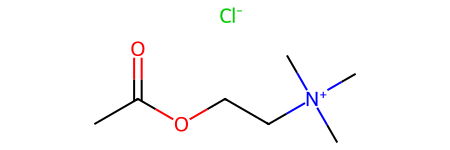

In [ ]:
c1 = df['mol_hba'].iloc[0]
c1

In [ ]:
graph_hba = df['g_hba'].iloc[0]
graph_hba

Data(x=[11, 24], edge_index=[2, 18], edge_attr=[18, 6], y=1129.300048828125, Temp=-1.0132721188766254, mol_x=-0.23955906276038672, ap=-0.4276447181267457, bp=-0.16738558778417115, topopsa=0.7347198251325129, hb=-0.9283268321215553, inter_hb=-0.36592804322710265)

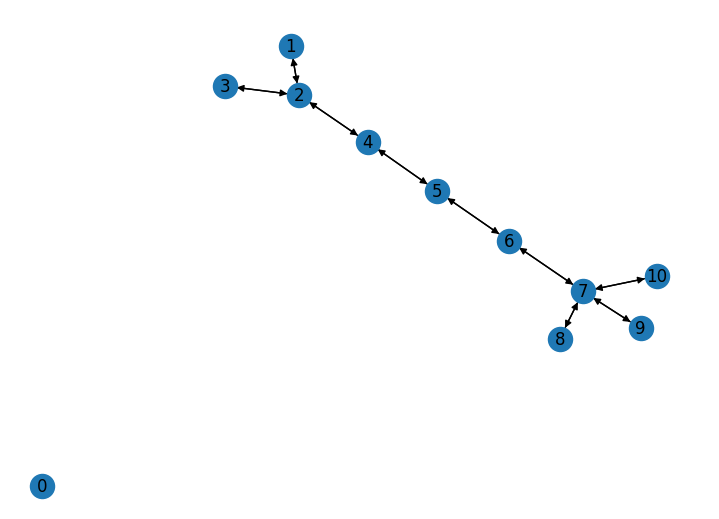

In [ ]:
# Convert the Data object to a networkx graph
nx_graph = to_networkx(graph_hba)

# Draw the graph
nx.draw(nx_graph, with_labels=True)
plt.show()

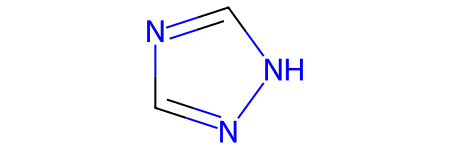

In [ ]:
c2 = df['mol_hbd'].iloc[0]
c2

In [ ]:
graph_hbd = df['g_hbd'].iloc[0]
graph_hbd

Data(x=[5, 24], edge_index=[2, 10], edge_attr=[10, 6], y=1129.300048828125, Temp=-1.0132721188766254, mol_x=-0.6632831720654729, ap=-1.2159096642335774, bp=-1.2636980544190353, topopsa=-0.712453150897509, hb=-1.1413645067950027, inter_hb=-0.36592804322710265)

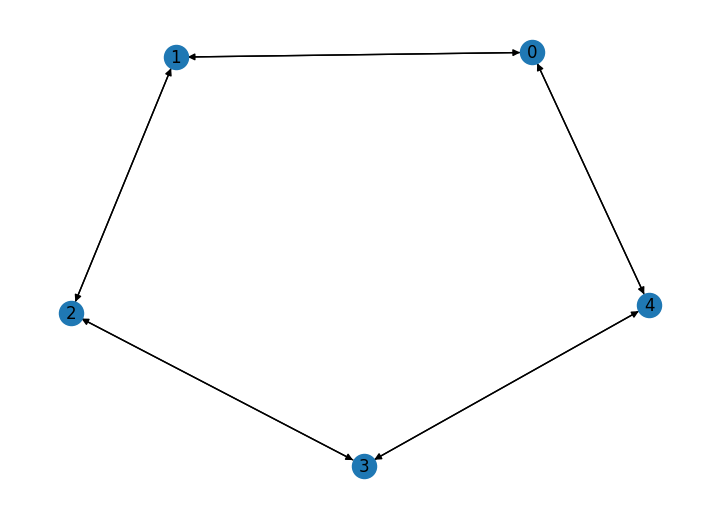

In [ ]:
# Convert the Data object to a networkx graph
nx_graph = to_networkx(graph_hbd)

# Draw the graph
nx.draw(nx_graph, with_labels=True)
plt.show()

## Graph Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn.pool import global_mean_pool


class MPNNconv(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats=32, num_step_message_passing=1):
        super(MPNNconv, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )

        self.num_step_message_passing = num_step_message_passing

        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats*node_out_feats)
        )
        self.gnn_layer = gnn.NNConv(
            node_out_feats,
            node_out_feats,
            edge_network,
            aggr='add'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def reset_parameters(self):
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, system_graph):

        node_feats = system_graph.x
        edge_index = system_graph.edge_index
        edge_feats = system_graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            if torch.cuda.is_available():
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor).cuda(),
                                                   edge_index=edge_index.type(torch.LongTensor).cuda(),
                                                   edge_attr=edge_feats.type(torch.FloatTensor).cuda()))
            else:
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor),
                                                   edge_index=edge_index.type(torch.LongTensor),
                                                   edge_attr=edge_feats.type(torch.FloatTensor)))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)
        return node_feats

class EdgeModel(torch.nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in*2 + e_in + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr, u[batch]], axis=1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, v_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.node_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0), reduce='sum')
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(hidden_dim + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.global_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        node_aggregate = scatter(x, batch, dim=0, reduce='sum')
        edge_aggregate = scatter(edge_attr, batch[edge_index[1]], dim=0, reduce='sum')
        out = torch.cat([u, node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

class GHGNN(nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim, n_extra_inputs):
        super(GHGNN, self).__init__()
        self.graphnet1 = gnn.MetaLayer(EdgeModel(v_in, e_in, u_in, hidden_dim),
                                      NodeModel(v_in, u_in, hidden_dim),
                                      GlobalModel(u_in, hidden_dim))
        self.graphnet2 = gnn.MetaLayer(EdgeModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim),
                                      NodeModel(hidden_dim, hidden_dim, hidden_dim),
                                      GlobalModel(hidden_dim, hidden_dim))

        self.gnorm1 = gnn.GraphNorm(hidden_dim)
        self.gnorm2 = gnn.GraphNorm(hidden_dim)

        self.pool = global_add_pool

        self.global_conv1 = MPNNconv(node_in_feats=hidden_dim*2,
                                     edge_in_feats=1,
                                     node_out_feats=hidden_dim*2)

        # MLP
        self.mlp1 = nn.Linear(hidden_dim*4 + n_extra_inputs, hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim, hidden_dim)
        self.mlp3 = nn.Linear(hidden_dim, 1)

        # Define ReLU activation
        self.relu = nn.ReLU() # Define the ReLU activation function

    def generate_sys_graph(self, x, edge_attr, batch_size, n_mols=2):

        src = np.arange(batch_size)
        dst = np.arange(batch_size, n_mols*batch_size)

        self_connection = np.arange(n_mols*batch_size)

        # Biderectional connections (between each molecule in the system)
        # and self-connection
        one_way = np.concatenate((src, dst, self_connection))
        other_way = np.concatenate((dst, src, self_connection))
        edge_index = torch.tensor([list(one_way),
                                   list(other_way)], dtype=torch.long)
        sys_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return sys_graph

    def forward(self, c1, c2):
        # ---- Atomic polarizability
        ap1 = c1.ap.reshape(-1,1)
        ap2 = c2.ap.reshape(-1,1)

        # ---- Bond polarizability
        bp1 = c1.bp.reshape(-1,1)
        bp2 = c2.bp.reshape(-1,1)

        # -- Polarity via topological polar surface area
        topopsa1 = c1.topopsa.reshape(-1,1)
        topopsa2 = c2.topopsa.reshape(-1,1)

        # -- Hydrogen-bond acidity and basicity
        intra_hb1 = c1.inter_hb
        intra_hb2 = c2.inter_hb

        u1 = torch.cat((ap1,bp1,topopsa1), axis=1) # Molecular descriptors molecule 1
        u2 = torch.cat((ap2,bp2,topopsa2), axis=1) # Molecular descriptors molecule 2

        # Molecule 1 GraphNet
        x1, edge_attr1, u1 = self.graphnet1(c1.x, c1.edge_index, c1.edge_attr, u1, c1.batch)
        x1 = self.gnorm1(x1, c1.batch)
        x1, edge_attr1, u1 = self.graphnet2(x1, c1.edge_index, edge_attr1, u1, c1.batch)
        x1 = self.gnorm2(x1, c1.batch)
        xg1 = self.pool(x1, c1.batch)

        # Molecule 2 GraphNet
        x2, edge_attr2, u2 = self.graphnet1(c2.x, c2.edge_index, c2.edge_attr, u2, c2.batch)
        x2 = self.gnorm1(x2, c2.batch)
        x2, edge_attr2, u2 = self.graphnet2(x2, c2.edge_index, edge_attr2, u2, c2.batch)
        x2 = self.gnorm2(x2, c2.batch)
        xg2 = self.pool(x2, c2.batch)

        batch_size = c1.y.shape[0]

        # Intermolecular descriptors
        # -- Hydrogen bonding
        inter_hb  = c1.inter_hb
        # Construct binary system graph
        node_feat = torch.cat((
            torch.cat((xg1, u1), axis=1),
            torch.cat((xg2, u2), axis=1)),axis=0)
        edge_feat = torch.cat((inter_hb.repeat(2),
                               intra_hb1,
                               intra_hb2)).unsqueeze(1)
        binary_sys_graph = self.generate_sys_graph(x=node_feat,
                                                   edge_attr=edge_feat,
                                                   batch_size=batch_size)
        xg = self.global_conv1(binary_sys_graph)


        xg = torch.cat((xg[0:len(xg)//2,:], xg[len(xg)//2:,:]), axis=1)

        T = torch.reshape(c1.Temp,(-1,1))
        ##P = torch.reshape(c2.P,(-1,1))
        x1 = torch.reshape(c1.mol_x,(-1,1))
        x2 = torch.reshape(c2.mol_x,(-1,1))

        ##ExtraVar = torch.cat((T,P,x1,x2),1)
        ExtraVar = torch.cat((T,x1,x2),1)
        x = torch.cat((xg,ExtraVar),1)
        ##x = F.sigmoid(self.mlp1(x))
        ##x = F.sigmoid(self.mlp2(x))

        # Apply ReLU after the first two linear layers
        x = self.relu(self.mlp1(x))
        x = self.relu(self.mlp2(x))

        x = self.mlp3(x)
        return x

class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class PairDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
    def __len__(self):
        return len(self.datasetA)

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB

def get_dataloader_pairs(df, graphs_c1, graphs_c2, batch_size, shuffle=False, drop_last=False):

    g1s = df[graphs_c1].tolist()
    g2s  = df[graphs_c2].tolist()

    pair_dataset = PairDataset(g1s, g2s)
    data_loader  = torch.utils.data.DataLoader(pair_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=collate)

    return data_loader

In [ ]:
train_df = df[df['Split'] == 'Train']
test_df = df[df['Split'] == 'Test']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [ ]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for batch_c1, batch_c2 in dataloader:
        y =  batch_c1.y
        X1 = batch_c1
        X2 = batch_c2
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X1, X2)
        loss = loss_fn(y_hat, y.reshape(-1,1))
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for batch_c1, batch_c2 in dataloader:
            y =  batch_c1.y
            X1 = batch_c1
            X2 = batch_c2
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Model prediction and loss calculation
            y_hat = model(X1, X2)
            loss = loss_fn(y_hat, y.reshape(-1,1))
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GHGNN(n_atom_features(), n_bond_features(), 3, 31, 3).to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
epochs = 1000

In [ ]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'GNN_interactions.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

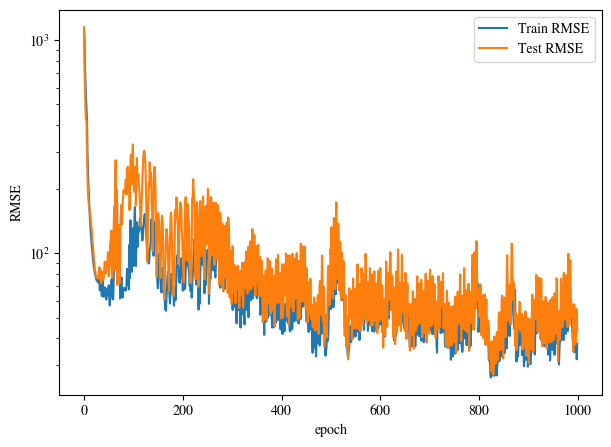

In [ ]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [ ]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 31, 3).to(device)
checkpoint = torch.load('GNN_interactions.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

In [ ]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'RMSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_train = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['train']['R2'],
      metrics_dict['train']['MAPE']*100,
      metrics_dict['train']['MAE'],
      metrics_dict['train']['RMSE']**0.5))

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['RMSE']**0.5))

  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(10.0 ,5.0))

  ax1.set_xlabel(r'$Density^{exp} [kg/m^3] $')
  ax1.set_ylabel(r'$Density^{pred} [kg/m^3] $')
  ax1.set_ylim([800,1500])
  ax1.set_xlim([800,1500])
  ax1.text(850,1300, metrics_train, fontsize=10)
  ax1.grid(visible=True,which='major',linestyle = '--' ,linewidth = 0.5)
  ax1.scatter(y_train, y_train_hat, label='Training', marker='s', color='red')
  ax1.plot(np.linspace(0,1500), np.linspace(0,1500),linestyle = '--' , color  = 'black')
  ax1.legend(loc="best")

  ax2.set_xlabel(r'$Density^{exp} [kg/m^3] $')
  ax2.set_ylabel(r'$Density^{pred} [kg/m^3] $')
  ax2.set_ylim([800,1500])
  ax2.set_xlim([800,1500])
  ax2.text(850,1300, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.scatter(y_test, y_test_hat, label='Testing', marker='s', color='blue')
  ax2.plot(np.linspace(0,1500),np.linspace(0,1500),linestyle = '--' , color  = 'black')
  ax2.legend(loc="best")

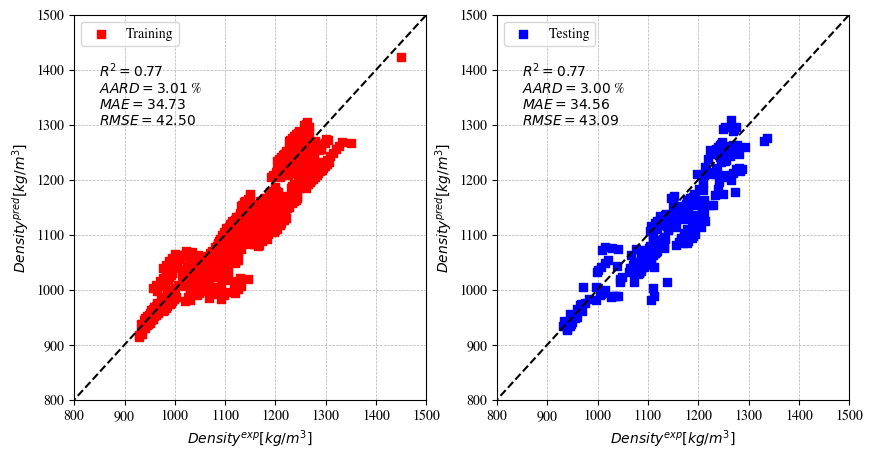

In [ ]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

## Hyperparameter optimization

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Hyperparameters to be optimized
    conv_dim = trial.suggest_int('graph convolution dimensions', 4, 32)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

    # Model and optimizer
    model = GHGNN(n_atom_features(), n_bond_features(), 3, conv_dim, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # K-fold cross-validation
    k = 5
    mapes = []
    train_data = train_df['HBA'].tolist()
    kf = KFold(n_splits=k, shuffle=True, random_state=42)


    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
      train_subdf = train_df.iloc[train_idx]
      val_subdf = train_df.iloc[val_idx]

      train_loader = get_dataloader_pairs(train_subdf, 'g_hba', 'g_hbd', batch_size=32, shuffle=True)
      val_loader = get_dataloader_pairs(val_subdf, 'g_hba', 'g_hbd', batch_size=32, shuffle=False)

      #print(f"Fold {fold + 1}")

      # training loop
      for epoch in tqdm(range(epochs)):
          train_loss = train(model, device, train_loader, optimizer, loss_fn)
      # evaluation
      y_valid, y_hat_valid = [] ,[]
      model.eval()
      with torch.no_grad():
        for batch_c1, batch_c2 in val_loader:
          X1 = batch_c1
          X2 = batch_c2
          X1, X2 = X1.to(device), X2.to(device)
          y_hat = model(X1, X2).cpu().numpy().tolist()

          y = X1.y
          y_valid.extend(y.cpu().numpy().tolist())
          y_hat_valid.extend(y_hat)

      val_mape = mean_absolute_percentage_error(y_valid, y_hat_valid)*100
      #print('---> Val MAPE: ', np.round(val_mape,3))
      mapes.append(val_mape)

    return np.mean(mapes)

In [ ]:
study_name = 'GNN_MG'
storage_traj = f'sqlite:///{study_name}.db'
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_traj, load_if_exists=True)

max_trials = 60
completed_trials = len(study.trials)
trials_left = max_trials - completed_trials
print('Trials left: ', trials_left)

if trials_left > 0:
    study.optimize(objective, n_trials=trials_left)
else:
    print("Maximum number of trials already reached or exceeded.")

[I 2025-08-07 08:45:22,308] Using an existing study with name 'GNN_MG' instead of creating a new one.


Trials left:  57


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 09:50:07,847] Trial 3 finished with value: 1.2218162637560108 and parameters: {'graph convolution dimensions': 24, 'lr': 0.004774921171272136}. Best is trial 3 with value: 1.2218162637560108.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 10:41:53,366] Trial 4 finished with value: 1.791749268091521 and parameters: {'graph convolution dimensions': 12, 'lr': 0.01347456237558617}. Best is trial 3 with value: 1.2218162637560108.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 11:44:44,037] Trial 5 finished with value: 1.1899326552368663 and parameters: {'graph convolution dimensions': 21, 'lr': 0.002600458630869128}. Best is trial 5 with value: 1.1899326552368663.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 12:37:32,381] Trial 6 finished with value: 1.2308828565676575 and parameters: {'graph convolution dimensions': 13, 'lr': 0.000547618916266312}. Best is trial 5 with value: 1.1899326552368663.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 13:36:31,116] Trial 7 finished with value: 1.192052131575434 and parameters: {'graph convolution dimensions': 19, 'lr': 0.00019131681662453166}. Best is trial 5 with value: 1.1899326552368663.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 14:26:11,712] Trial 8 finished with value: 1.1740588813500736 and parameters: {'graph convolution dimensions': 10, 'lr': 0.0019387587734623277}. Best is trial 8 with value: 1.1740588813500736.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 15:18:31,485] Trial 9 finished with value: 1.345030774915762 and parameters: {'graph convolution dimensions': 13, 'lr': 0.0011799230358922972}. Best is trial 8 with value: 1.1740588813500736.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-08-07 16:05:55,028] Trial 10 finished with value: 1.2106662031644007 and parameters: {'graph convolution dimensions': 7, 'lr': 0.00392197622221571}. Best is trial 8 with value: 1.1740588813500736.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]